# Valoración de Opciones Europeas: Método de Monte Carlo

El modelo de **Black-Scholes-Merton (BSM)** asume que el precio de un activo subyacente sigue un **Movimiento Browniano Geométrico (GBM)**. Para valorar una opción mediante simulación, discretizamos esta dinámica bajo la medida neutral al riesgo.

La ecuación para simular el precio del activo $S_T$ en el tiempo de vencimiento $T$ es:

$$S_T = S_0 \cdot \exp\left( (r - 0.5 \cdot \sigma^2) T + \sigma \sqrt{T} \cdot z \right)$$

Donde:
* $S_0$: Precio actual del activo.
* $r$: Tasa libre de riesgo.
* $\sigma$: Volatilidad del activo.
* $z$: Variable aleatoria estándar normal $\mathcal{N}(0, 1)$.

El valor de una **Opción Call Europea** se estima calculando el promedio de los pagos (payoffs) descontados:

$$C_0 = e^{-rT} \cdot \frac{1}{I} \sum_{i=1}^{I} \max(S_T^{(i)} - X, 0)$$

In [1]:
import numpy as np  # Importamos numpy con el alias estándar np

# === Parámetros del Mercado y de la Opción (Caso: NVIDIA) ===
S0 = 187.24     # Precio actual del activo subyacente (Spot Price)
X = 190.0       # Precio de ejercicio (Strike Price)
T = 1.0         # Tiempo hasta el vencimiento en años
r = 0.03622     # Tasa libre de riesgo anualizada (3.622%)
sigma = 0.7911  # Volatilidad del activo (79.11%)

# === Configuración de la Simulación ===
I = 100000      # Número de simulaciones (iteraciones)

# === Simulación de Monte Carlo ===
# 1. Generar I números aleatorios distribuidos normalmente (z ~ N(0,1))
z = np.random.standard_normal(I)

# 2. Calcular los precios futuros al vencimiento (ST) usando la fórmula de Movimiento Browniano Geométrico
#    La fórmula vectorizada calcula los 100,000 precios simultáneamente.
ST = S0 * np.exp((r - 0.5 * sigma ** 2) * T + sigma * np.sqrt(T) * z)

# 3. Calcular el Payoff (pago) al vencimiento para una opción Call
#    hT = max(ST - X, 0). Si ST < X, la opción no se ejerce y vale 0.
hT = np.maximum(ST - X, 0) 

# 4. Descontar el promedio de los pagos al valor presente
#    Se usa np.mean(hT) para obtener el valor esperado E[hT]
C0 = np.exp(-r * T) * np.mean(hT)

print(f"El valor estimado de la opción Call es: {C0:.4f}")

El valor estimado de la opción Call es: 59.6037


# Cálculo de Volatilidad Implícita

La **Volatilidad Implícita** es el valor de $\sigma$ que, al ser introducido en el modelo de valoración, hace que el precio teórico de la opción coincida con el precio observado en el mercado ($C_{market}$).

Dado que la fórmula de Black-Scholes (o su versión Monte Carlo) no se puede invertir algebraicamente para despejar $\sigma$, utilizamos métodos numéricos de búsqueda de raíces. Definimos una función objetivo:

$$f(\sigma) = C_{modelo}(\sigma) - C_{mercado} = 0$$

Utilizamos el algoritmo de **Brent** (`brentq` de SciPy) para encontrar la raíz de esta función, es decir, la volatilidad que reduce la diferencia a cero.

In [2]:
import numpy as np
from scipy.optimize import brentq  # Algoritmo eficiente para búsqueda de raíces

# === Función de Precio por Monte Carlo ===
def montecarlo_call_price(S0, X, T, r, sigma, I=100000):
    """
    Calcula el precio de una opción Call Europea usando simulación de Monte Carlo.
    """
    np.random.seed(42) # Opcional: Semilla para reproducibilidad en pruebas
    z = np.random.standard_normal(I)
    ST = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * z)
    hT = np.maximum(ST - X, 0)
    C0 = np.exp(-r * T) * np.mean(hT)
    return C0

# === Función para obtener la Volatilidad Implícita ===
def implied_volatility_mc(C_market, S0, X, T, r, I=100000):
    """
    Encuentra la volatilidad que iguala el precio Monte Carlo con el precio de mercado.
    """
    # Definimos la función objetivo: f(sigma) = Precio_Calculado - Precio_Mercado
    # Buscamos que esta resta sea 0.
    objective = lambda sigma: montecarlo_call_price(S0, X, T, r, sigma, I) - C_market
    
    # brentq busca la raíz (donde la función es 0) en el intervalo [0.001, 5.0]
    # Esto asume que la volatilidad está entre 0.1% y 500%.
    try:
        iv = brentq(objective, 0.001, 5.0)
    except ValueError:
        iv = np.nan # Retorna NaN si no encuentra solución en el rango
        print("No se encontró solución en el rango de volatilidad especificado.")
        
    return iv

# === Ejecución del Ejemplo (Caso NVDA) ===
S0 = 187.24       # Precio spot
X = 190           # Strike
T = 1             # Tiempo (1 año)
r = 0.03622       # Tasa libre de riesgo
C_market = 32.5   # Precio observado de la Call en el mercado

# Calculamos la IV usando 200,000 simulaciones para mayor precisión
iv = implied_volatility_mc(C_market, S0, X, T, r, I=200000)

print(f"Precio de Mercado: {C_market}")
print(f"Volatilidad Implícita calculada (Monte Carlo): {iv*100:.2f}%")

Precio de Mercado: 32.5
Volatilidad Implícita calculada (Monte Carlo): 41.48%


# Análisis de Sentimiento de Mercado: Visualización de Datos No Estructurados

En las finanzas cuantitativas modernas, una gran parte de la información relevante no proviene de tablas de precios, sino de **datos no estructurados** como noticias, informes de ganancias y redes sociales. El Procesamiento de Lenguaje Natural (NLP) nos permite cuantificar esta información cualitativa.

Una técnica exploratoria inicial es la creación de **Nubes de Palabras (Word Clouds)**. Esta visualización nos permite identificar rápidamente los temas dominantes o "narrativas" en el mercado.

* **Frecuencia de Términos:** El tamaño de cada palabra es proporcional a su frecuencia de aparición en los titulares.
* **Stopwords (Palabras vacías):** Para obtener insights valiosos, es crucial filtrar palabras comunes (como "el", "la", "y") y, en el contexto financiero, los nombres de las propias empresas (como "Amazon" o "Stock"), para centrarnos en los adjetivos o verbos que describen la acción del mercado (ej. "caída", "rally", "inflación").

Para aplicar técnicas de Machine Learning en finanzas (como NLP), el primer paso es la **Ingestión de Datos**. A diferencia de los precios históricos (series de tiempo numéricas), las noticias requieren un pre-procesamiento para extraer el texto relevante.

Utilizaremos la librería `yfinance` como un *wrapper* para acceder a la API de Yahoo Finance, obteniendo metadatos y noticias recientes de empresas específicas. El objetivo es estructurar esta información en DataFrames para su posterior análisis de sentimiento.

In [5]:
# === IMPORTACIÓN DE LIBRERÍAS ===
import pandas as pd
import yfinance as yf

# ==========================================
# CASO 1: AMAZON (AMZN)
# ==========================================

# Instanciamos el objeto Ticker para Amazon
amzn_fundamental = yf.Ticker("AMZN")

# .info devuelve un diccionario JSON con datos fundamentales (Sector, PE Ratio, Beta, etc.)
# Es útil para verificar que la conexión es correcta
# print(amzn_fundamental.info) # Descomentar si se quiere ver la info completa

# Obtener las noticias más recientes
# Esto devuelve una lista de diccionarios con metadatos de los artículos
news = amzn_fundamental.get_news()

# Extraer los títulos de cada noticia usando List Comprehension
# Navegamos dentro de la estructura del JSON: articulo -> content -> title
news_titles = [article['content']['title'] for article in news if article.get('content') is not None]

# Crear un DataFrame estructurado
amzn_news = pd.DataFrame(news_titles, columns=['Title'])

# Mostrar las primeras filas para verificar
print("--- Noticias de Amazon ---")
print(amzn_news.head())


# ==========================================
# CASO 2: NVIDIA (NVDA)
# ==========================================

# Uso de la herramienta Yahoo Finance para obtener datos de NVDA
nvda_fundamental = yf.Ticker("NVDA")

# Obtener lista de noticias
news = nvda_fundamental.get_news()

# Extraer títulos filtrando aquellos que no tengan contenido (Manejo de errores básico)
news_titles = [article['content']['title'] for article in news if article['content'] is not None]

# Crear DataFrame
nvda_news = pd.DataFrame(news_titles, columns=['Title'])

print("\n--- Noticias de Nvidia ---")
print(nvda_news.head())


# ==========================================
# CASO 3: S&P 500 ETF (SPY)
# ==========================================

# Instanciamos el objeto para el ETF del mercado
spy_fundamental = yf.Ticker("SPY")

# Obtener noticias del mercado general
news = spy_fundamental.get_news()

# Extraer títulos con validación de contenido
news_titles = [article['content']['title'] for article in news if article['content'] is not None]

# Crear DataFrame
spy_news = pd.DataFrame(news_titles, columns=['Title'])

print("\n--- Noticias de SPY ---")
print(spy_news.head())

--- Noticias de Amazon ---
                                               Title
0  Nvidia launches Vera Rubin, its next major AI ...
1  Nvidia Shares Slide From Record as AI Spending...
2  Nvidia CEO Says Next-Gen AI Chips Now in Full ...
3  Amazon Must Face U.S. Price-Gouging Lawsuit, J...
4  Kevin O' Leary Says If He Woke Up Broke And Ha...

--- Noticias de Nvidia ---
                                               Title
0  Autonomous driving has potential, but this is ...
1  Nvidia Vera Rubin, Dow tops 49K, business opti...
2  Nvidia CEO: This AI 'breakthrough' is 'complet...
3  Hyundai is taking on Tesla and others in race ...
4  Nvidia CEO confirms Vera Rubin AI platform is ...

--- Noticias de SPY ---
                                               Title
0  Baby Boomers: 5 Simple Steps For A Prosperous ...
1  Exchange-Traded Funds Higher, Equity Futures M...
2  4 Office Products Stocks Are Fighting Remote W...
3  If You'd Thrown $1,000 at the SPDR S&P 500 ETF...
4  Exchange-Traded 


Total de noticias recopiladas: 30


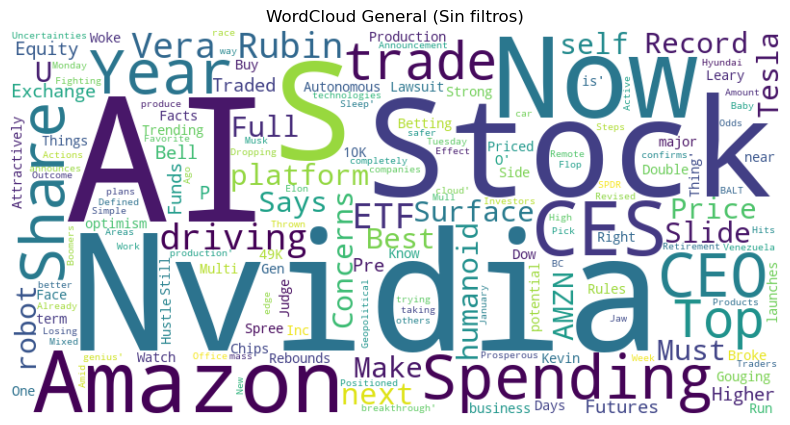

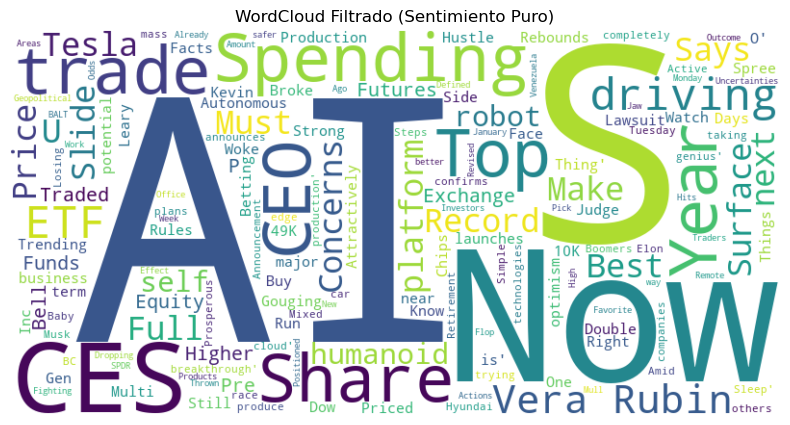

In [6]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

# === CONSOLIDACIÓN DE DATOS ===
# Unir los tres DataFrames (AMZN, NVDA, SPY) en uno solo para análisis conjunto
market_news = pd.concat([amzn_news, nvda_news, spy_news], ignore_index=True)

print(f"\nTotal de noticias recopiladas: {len(market_news)}")

# === VISUALIZACIÓN 1: Nube de Palabras Básica ===
# Concatenar todos los títulos en un solo string gigante
text = " ".join(market_news["Title"])

# Crear la nube de palabras básica
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Mostrar la nube de palabras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud General (Sin filtros)")
plt.show()

# === VISUALIZACIÓN 2: Nube de Palabras Refinada ===
# Definir palabras a excluir (Stopwords) para limpiar el ruido
custom_stopwords = set(STOPWORDS)
# Agregamos términos financieros y nombres propios que saturan la imagen
custom_stopwords.update(["amzn", "nvda", "stock", "Amazon", "Nvidia", "Nasdaq", "Stocks", "market", "today"])

# Crear la nube de palabras con stopwords personalizadas
wordcloud_filtered = WordCloud(
    width=800, 
    height=400, 
    background_color='white', 
    stopwords=custom_stopwords
).generate(text)

# Mostrar la nube de palabras filtrada
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_filtered, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud Filtrado (Sentimiento Puro)")
plt.show()

In [7]:
# === EXTRACCIÓN MASIVA ===
# Lista de tickers de las acciones que queremos analizar
tickers = ["NVDA", "SPY", "WMT", "UNH", "XOM", "JPM", "GS", "AMZN", "DIS", "PG", "V"]

# Lista para almacenar las noticias de cada ticker
news_data = []

print("Iniciando extracción masiva...")

# Iterar sobre cada empresa
for ticker in tickers:
    stock = yf.Ticker(ticker)  # Crear objeto de la acción
    news = stock.get_news()    # Obtener noticias

    # Extraer el título, fecha y ticker
    for article in news:
        # Verificamos que el contenido exista para evitar errores
        if article.get('content') is not None:
            news_data.append({
                "Title": article['content']['title'],
                "Date": article['content']['pubDate'],
                "Ticker": ticker
            })

# Crear un DataFrame con las noticias consolidadas
market_news2 = pd.DataFrame(news_data)

# Mostrar el DataFrame
print(market_news2.head())

# === GUARDADO DE RESULTADOS EN OUTPUT ===
# Guardamos en la carpeta 'output' ya que es un resultado procesado del script
# Asegúrate de que la carpeta 'output' exista en el directorio superior
import os

# Verificación opcional: crea la carpeta output si no existe
if not os.path.exists('../output'):
    os.makedirs('../output')

market_news2.to_csv("../output/market_news_consolidated.csv", index=False)
print("Archivo 'market_news_consolidated.csv' guardado exitosamente en la carpeta output.")

Iniciando extracción masiva...
                                               Title                  Date  \
0  Autonomous driving has potential, but this is ...  2026-01-06T15:16:43Z   
1  Nvidia Vera Rubin, Dow tops 49K, business opti...  2026-01-06T14:03:26Z   
2  Nvidia CEO: This AI 'breakthrough' is 'complet...  2026-01-06T11:30:42Z   
3  Hyundai is taking on Tesla and others in race ...  2026-01-05T21:00:56Z   
4  Nvidia CEO confirms Vera Rubin AI platform is ...  2026-01-05T23:07:11Z   

  Ticker  
0   NVDA  
1   NVDA  
2   NVDA  
3   NVDA  
4   NVDA  
Archivo 'market_news_consolidated.csv' guardado exitosamente en la carpeta output.


# 3. Conclusiones y Resumen del Módulo Introductorio

En este primer notebook, hemos establecido las bases del **Machine Learning aplicado a Finanzas**, demostrando cómo las técnicas cuantitativas tradicionales y las modernas herramientas de ciencia de datos pueden coexistir.

### 1. Valoración de Derivados (El Enfoque Cuantitativo Clásico)
Implementamos el modelo de **Black-Scholes-Merton (BSM)** mediante simulación de **Monte Carlo**.
* **Simulación Estocástica:** Demostramos que los precios de los activos no son lineales, sino que siguen un *Movimiento Browniano Geométrico*. Al simular miles de trayectorias posibles ($100,000+$ iteraciones), pudimos aproximar el valor justo de una opción Call Europea bajo la medida neutral al riesgo.
* **Volatilidad Implícita (IV):** Resolvimos el "problema inverso". Dado un precio de mercado, utilizamos métodos numéricos (algoritmo de Brent) para despejar la volatilidad ($\sigma$). Esto es crucial porque la IV representa la **expectativa de riesgo del mercado** hacia el futuro, a diferencia de la volatilidad histórica que solo mira al pasado.

### 2. Análisis de Sentimiento (El Enfoque de Data Science Moderno)
Exploramos el vasto mundo de los **Datos No Estructurados** mediante técnicas de Procesamiento de Lenguaje Natural (NLP).
* **Ingeniería de Datos:** Automatizamos la extracción de titulares de noticias financieras utilizando la API de `yfinance`, estructurando información cualitativa en DataFrames manejables.
* **Limpieza y Visualización:** Aprendimos que la "señal" a menudo se esconde detrás del "ruido". Mediante la eliminación de *Stopwords* (palabras vacías y nombres propios), creamos **Nubes de Palabras (WordClouds)** que revelan las narrativas dominantes del mercado (ej. "Inflation", "Earnings", "Recession").

### Conclusión Final
Este módulo cierra la brecha entre el "Quant" tradicional (ecuaciones diferenciales y cálculo estocástico) y el "Data Scientist" moderno (scraping y NLP).
* Mientras el **Modelo BSM** nos dice *cuánto* debería valer un activo basándose en las matemáticas,
* El **Análisis de Noticias** nos da pistas sobre *por qué* se está moviendo el mercado basándose en la psicología de masas.

El siguiente paso natural es combinar estos enfoques: utilizar el sentimiento extraído de las noticias como una variable (feature) para predecir los movimientos de precios o la volatilidad futura.